# Reproduction FastGCN Paper



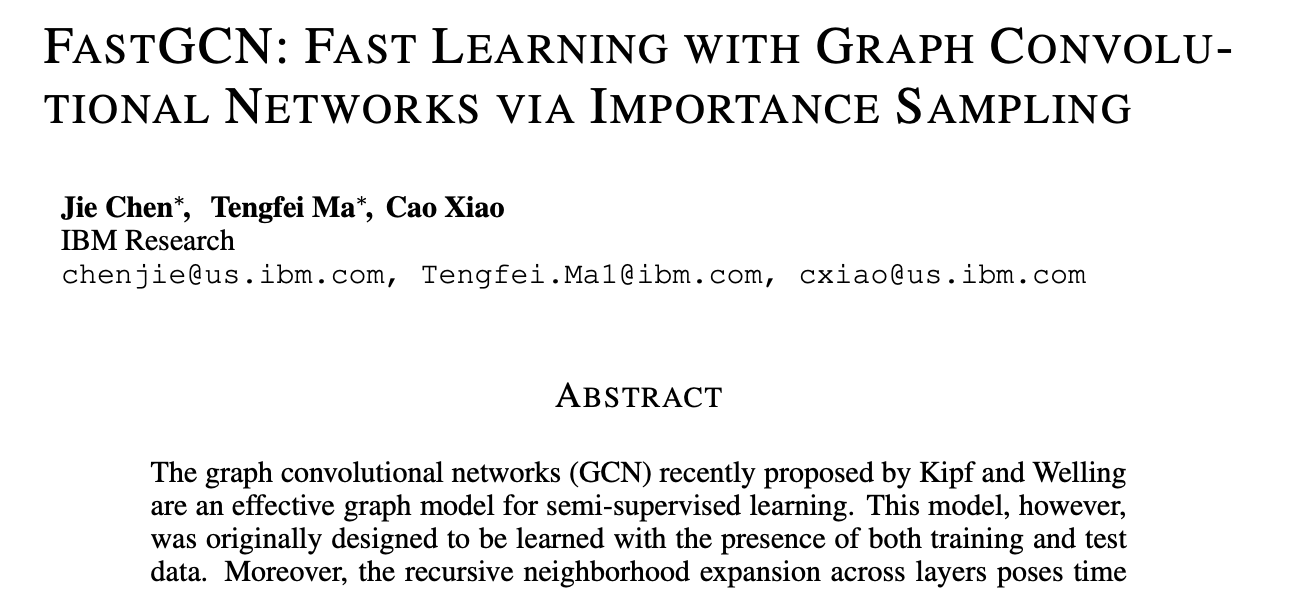

## Notes
- How well documented does code have to be?
- Reddti dataset too big for RAM

-> Check variance of sampled nodes!

## Imports


In [ ]:
!pip install torch-geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid, Reddit
from sklearn.metrics import f1_score
import numpy as np
import os.path as osp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:00


## Configuration & Hyperparameters

In [ ]:
DATASET_CONFIG = {
    'Cora': {
        'hidden_channels': 16,
        'sample_size': 400,
        'batch_size': 256,
        'lr': 0.01,
        'weight_decay': 5e-4,
        'root': '/tmp/Cora'
    },
    'Pubmed': {
        'hidden_channels': 16,
        'sample_size': 100,
        'batch_size': 1024,
        'lr': 0.01,
        'weight_decay': 5e-4,
        'root': '/tmp/Pubmed'
    },
    'Reddit': {
        'hidden_channels': 128,
        'sample_size': 400,
        'batch_size': 256,
        'lr': 0.01,
        'weight_decay': 0,
        'root': '/tmp/Reddit'
    }
}


## Data Loading & Split Logic


In [ ]:
def get_dataset(name):
    cfg = DATASET_CONFIG[name]

    if name == 'Reddit':
        dataset = Reddit(root=cfg['root'])
        data = dataset[0]

        return dataset, data

    else: # Cora or Pubmed
        dataset = Planetoid(root=cfg['root'], name=name)
        data = dataset[0]
        data.train_mask = ~(data.val_mask | data.test_mask)

        return dataset, data

## Utilities: Precomputation & Probabilities


In [ ]:
def compute_fastgcn_probs(edge_index, num_nodes):
    """
    Computes uniform sampling distribution
    """
    # Add self loops for degree calculation (needed for GCN normalization)
    loop_index = torch.arange(num_nodes, device=edge_index.device).unsqueeze(0).repeat(2, 1)
    edge_index_sl = torch.cat([edge_index, loop_index], dim=1)
    row, col = edge_index_sl

    #Calculate degrees
    deg = torch.bincount(row, minlength=num_nodes).float()

    # UNIFORM SAMPLING: Every node has 1/N probability
    probs = torch.full((num_nodes,), 1.0 / num_nodes, device=edge_index.device)

    return probs, deg, edge_index_sl

@torch.no_grad()
def precompute_first_layer(x, edge_index, deg):
    """
    Precomputes A_hat * H (0)
    """
    row, col = edge_index
    norm = 1.0 / torch.sqrt(deg[row] * deg[col])

    out = torch.zeros((x.size(0), x.size(1)), device=x.device)
    out.index_add_(0, row, norm.unsqueeze(1) * x[col])
    return out

@torch.no_grad()
def precompute_first_layer(x, edge_index, deg):
    row, col = edge_index
    num_nodes = x.size(0)

    #normalization
    norm = 1.0 / torch.sqrt(deg[row] * deg[col])

    A_sparse = torch.sparse_coo_tensor(edge_index, norm, (num_nodes, num_nodes)).to(x.device)
    return torch.sparse.mm(A_sparse, x)

## Model Definition


In [ ]:
class FastGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.W = nn.Linear(in_channels, out_channels, bias=False)

    def forward(self, x, edge_index, deg, sampled_nodes=None, probs=None, prev_nodes=None, num_nodes=None):
        if self.training and sampled_nodes is not None:
            row, col = edge_index
            mask = (torch.isin(row, prev_nodes) & torch.isin(col, sampled_nodes))
            row, col = row[mask], col[mask]

            norm = 1.0 / torch.sqrt(deg[row] * deg[col])

            weight = norm / (probs[col] * len(sampled_nodes))

            h_u = self.W(x[col])

            u_prev, _ = torch.unique(prev_nodes, sorted=True, return_inverse=True)
            prev_map = torch.full((num_nodes,), -1, dtype=torch.long, device=x.device)
            prev_map[u_prev] = torch.arange(len(u_prev), device=x.device)
            local_row = prev_map[row]

            out = torch.zeros(len(prev_nodes), self.W.out_features, device=x.device)
            out.index_add_(0, local_row, weight.unsqueeze(1) * h_u)
            return out
        # for inferecne use full neighbourhood
        else:
            row, col = edge_index
            norm = 1.0 / torch.sqrt(deg[row] * deg[col])
            h = self.W(x)
            out = torch.zeros((x.size(0), self.W.out_features), device=x.device)
            out.index_add_(0, row, norm.unsqueeze(1) * h[col])
            return out

class FastGCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, sample_size):
        super().__init__()
        self.sample_size = sample_size
        #Layer 1 is precomputed
        self.W1 = nn.Linear(in_channels, hidden_channels, bias=False)
        self.conv2 = FastGCNLayer(hidden_channels, out_channels)

    def forward(self, x_precomputed, edge_index, deg, probs, target_nodes, num_nodes):
        if self.training:
            # apply weights to precomputed features
            h1 = F.relu(self.W1(x_precomputed))

            # sample nodes for Layer 2
            sampled_l1 = torch.multinomial(probs, self.sample_size, replacement=True)

            # conv Layer 2 using sampled nodes
            out = self.conv2(h1, edge_index, deg, sampled_l1, probs, target_nodes, num_nodes)
        else:
            h1 = F.relu(self.W1(x_precomputed))
            out = self.conv2(h1, edge_index, deg)
            out = out[target_nodes]

        return F.log_softmax(out, dim=1)



## Training Run Definition

In [ ]:
import time

def run(dataset_name='Pubmed'):
    print(f"--- Running FastGCN on {dataset_name} ---")
    cfg = DATASET_CONFIG[dataset_name]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # load Data
    dataset, data = get_dataset(dataset_name)
    data = data.to(device)

    print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}, Features: {data.num_features}")
    print(f"Train nodes: {data.train_mask.sum().item()}, Val: {data.val_mask.sum().item()}, Test: {data.test_mask.sum().item()}")

    # preprocessing
    print("Computing probabilities...")
    probs, deg, edge_index = compute_fastgcn_probs(data.edge_index, data.num_nodes)

    print("Precomputing first layer (A_hat * X)...")
    x_precomputed = precompute_first_layer(data.x, edge_index, deg)

    print("Defining model...")
    model = FastGCNModel(
        in_channels=data.num_features,
        hidden_channels=cfg['hidden_channels'],
        out_channels=dataset.num_classes,
        sample_size=cfg['sample_size']
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])

    def train():
        model.train()
        optimizer.zero_grad()
        train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
        out = model(x_precomputed, edge_index, deg, probs, train_idx, data.num_nodes)
        loss = F.nll_loss(out, data.y[train_idx])
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def test():
        model.eval()
        def get_f1(mask):
            idx = mask.nonzero(as_tuple=False).view(-1)
            out = model(x_precomputed, edge_index, deg, probs, idx, data.num_nodes)
            pred = out.argmax(dim=1).cpu().numpy()
            label = data.y[idx].cpu().numpy()
            return f1_score(label, pred, average='micro')

        return get_f1(data.train_mask), get_f1(data.val_mask), get_f1(data.test_mask)

    print("Starting training...")
    epoch_times = []

    for epoch in range(0, 201):
        if device.type == 'cuda': torch.cuda.synchronize()
        start_time = time.time()

        loss = train()

        if device.type == 'cuda': torch.cuda.synchronize()
        end_time = time.time()

        epoch_duration = end_time - start_time
        epoch_times.append(epoch_duration)

        if epoch % 20 == 0:
            tr, va, te = test()
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Speed: {epoch_duration:.4f}s/epoch | Train F1: {tr:.4f} | Val F1: {va:.4f} | Test F1: {te:.4f}")

    avg_speed = sum(epoch_times) / len(epoch_times)
    print(f"\nTraining complete. Average speed: {avg_speed:.4f} seconds per epoch.")

    return te

In [ ]:
run('Pubmed')
run('Pubmed')
run('Pubmed')
run('Cora')
run('Cora')
run('Cora')
#run('Reddit')

--- Running FastGCN on Pubmed ---


Processing...
Done!


Nodes: 19717, Edges: 88648, Features: 500
Train nodes: 18217, Val: 500, Test: 1000
Computing probabilities...
Precomputing first layer (A_hat * X)...
Defining model...
Starting training...
Epoch 000 | Loss: 1.0991 | Speed: 0.1693s/epoch | Train F1: 0.5199 | Val F1: 0.5540 | Test F1: 0.5240
Epoch 020 | Loss: 1.0818 | Speed: 0.0587s/epoch | Train F1: 0.8548 | Val F1: 0.8820 | Test F1: 0.8690
Epoch 040 | Loss: 1.0853 | Speed: 0.0945s/epoch | Train F1: 0.8449 | Val F1: 0.8660 | Test F1: 0.8560
Epoch 060 | Loss: 1.0814 | Speed: 0.1576s/epoch | Train F1: 0.8468 | Val F1: 0.8620 | Test F1: 0.8490
Epoch 080 | Loss: 1.0815 | Speed: 0.0431s/epoch | Train F1: 0.8565 | Val F1: 0.8800 | Test F1: 0.8620
Epoch 100 | Loss: 1.0861 | Speed: 0.0416s/epoch | Train F1: 0.8488 | Val F1: 0.8740 | Test F1: 0.8440
Epoch 120 | Loss: 1.0848 | Speed: 0.0491s/epoch | Train F1: 0.8593 | Val F1: 0.8760 | Test F1: 0.8590
Epoch 140 | Loss: 1.0801 | Speed: 0.0408s/epoch | Train F1: 0.8574 | Val F1: 0.8720 | Test F1: 0.

KeyboardInterrupt: 

Running experiments for sample size: 128...
--- Running FastGCN on Cora ---
Nodes: 2708, Edges: 10556, Features: 1433
Train nodes: 1208, Val: 500, Test: 1000
Computing probabilities...
Precomputing first layer (A_hat * X)...
Defining model...
Starting training...
Epoch 000 | Loss: 1.9467 | Speed: 0.0192s/epoch | Train F1: 0.4346 | Val F1: 0.4500 | Test F1: 0.4510
Epoch 020 | Loss: 1.6289 | Speed: 0.0153s/epoch | Train F1: 0.9172 | Val F1: 0.8540 | Test F1: 0.8520
Epoch 040 | Loss: 1.5409 | Speed: 0.0125s/epoch | Train F1: 0.9404 | Val F1: 0.8640 | Test F1: 0.8590
Epoch 060 | Loss: 1.6290 | Speed: 0.0127s/epoch | Train F1: 0.9503 | Val F1: 0.8560 | Test F1: 0.8630
Epoch 080 | Loss: 1.6464 | Speed: 0.0126s/epoch | Train F1: 0.9503 | Val F1: 0.8600 | Test F1: 0.8500
Epoch 100 | Loss: 1.6558 | Speed: 0.0131s/epoch | Train F1: 0.9512 | Val F1: 0.8540 | Test F1: 0.8590
Epoch 120 | Loss: 1.6805 | Speed: 0.0152s/epoch | Train F1: 0.9619 | Val F1: 0.8580 | Test F1: 0.8620
Epoch 140 | Loss: 1.64

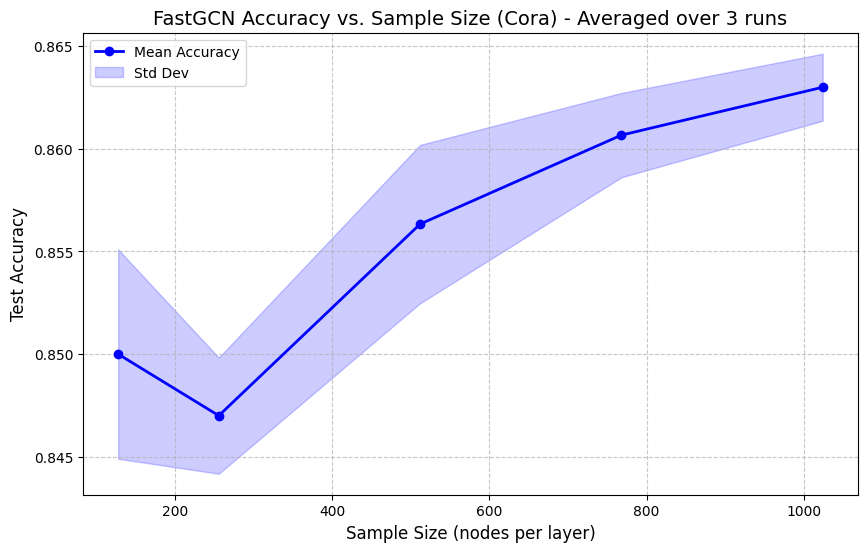

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

results_all_runs = []
sample_sizes = [128, 256, 512, 768, 1024]
num_runs = 3

for size in sample_sizes:
    current_size_results = []
    print(f"Running experiments for sample size: {size}...")

    for i in range(num_runs):
        DATASET_CONFIG = {
            'Cora': {
                'hidden_channels': 16,
                'sample_size': size,
                'batch_size': 256,
                'lr': 0.01,
                'weight_decay': 5e-4,
                'root': '/tmp/Cora'
            }
        }
        acc = run('Cora')
        current_size_results.append(acc)

    results_all_runs.append(current_size_results)

results_arr = np.array(results_all_runs)
avg_results = results_arr.mean(axis=1)
std_results = results_arr.std(axis=1)

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot the average line
plt.plot(sample_sizes, avg_results, marker='o', linestyle='-', color='blue', linewidth=2, label='Mean Accuracy')

# Add a shaded area for standard deviation (shows the variance/noise)
plt.fill_between(sample_sizes, avg_results - std_results, avg_results + std_results, color='blue', alpha=0.2, label='Std Dev')

# Adding labels and titles
plt.title('FastGCN Accuracy vs. Sample Size (Cora) - Averaged over 3 runs', fontsize=14)
plt.xlabel('Sample Size (nodes per layer)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)

# Adding a grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

Running Pubmed experiments for sample size: 128...
--- Running FastGCN on Pubmed ---
Nodes: 19717, Edges: 88648, Features: 500
Train nodes: 18217, Val: 500, Test: 1000
Computing probabilities...
Precomputing first layer (A_hat * X)...
Defining model...
Starting training...
Epoch 000 | Loss: 1.0989 | Speed: 0.0406s/epoch | Train F1: 0.6266 | Val F1: 0.6260 | Test F1: 0.6020
Epoch 020 | Loss: 1.0777 | Speed: 0.0593s/epoch | Train F1: 0.8438 | Val F1: 0.8620 | Test F1: 0.8400
Epoch 040 | Loss: 1.0800 | Speed: 0.0624s/epoch | Train F1: 0.8594 | Val F1: 0.8800 | Test F1: 0.8590
Epoch 060 | Loss: 1.0844 | Speed: 0.0401s/epoch | Train F1: 0.8476 | Val F1: 0.8540 | Test F1: 0.8490
Epoch 080 | Loss: 1.0792 | Speed: 0.0426s/epoch | Train F1: 0.8624 | Val F1: 0.8740 | Test F1: 0.8640
Epoch 100 | Loss: 1.0826 | Speed: 0.0405s/epoch | Train F1: 0.8604 | Val F1: 0.8880 | Test F1: 0.8500
Epoch 120 | Loss: 1.0730 | Speed: 0.0405s/epoch | Train F1: 0.8620 | Val F1: 0.8840 | Test F1: 0.8590
Epoch 140 | 

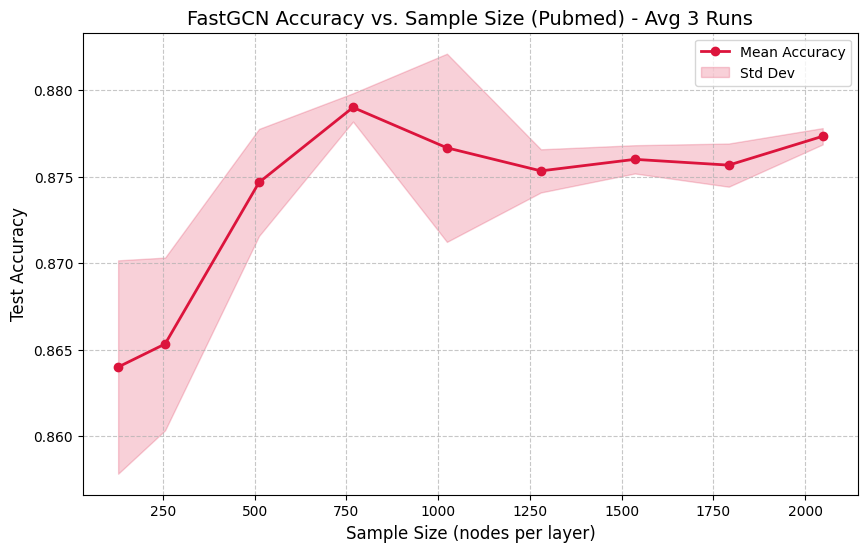

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

results_all_runs = []
sample_sizes = [128, 256, 512, 768, 1024, 1280, 1536, 1792, 2048]
num_runs = 3

for size in sample_sizes:
    current_size_results = []
    print(f"Running Pubmed experiments for sample size: {size}...")

    for i in range(num_runs):
        DATASET_CONFIG = {
          'Pubmed': {
              'hidden_channels': 16,
              'sample_size': size,
              'batch_size': 1024,
              'lr': 0.01,
              'weight_decay': 5e-4,
              'root': '/tmp/Pubmed'
          }
        }
        acc = run('Pubmed')
        current_size_results.append(acc)

    results_all_runs.append(current_size_results)

results_arr = np.array(results_all_runs)
avg_results = results_arr.mean(axis=1)
std_results = results_arr.std(axis=1)

# --- Plotting ---
plt.figure(figsize=(10, 6))

plt.plot(sample_sizes, avg_results, marker='o', linestyle='-', color='crimson', linewidth=2, label='Mean Accuracy')
plt.fill_between(sample_sizes, avg_results - std_results, avg_results + std_results, color='crimson', alpha=0.2, label='Std Dev')

plt.title('FastGCN Accuracy vs. Sample Size (Pubmed) - Avg 3 Runs', fontsize=14)
plt.xlabel('Sample Size (nodes per layer)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

In [ ]:
print(results_arr)
print(avg_results)
print(std_results)

[[0.852 0.843 0.855]
 [0.845 0.845 0.851]
 [0.858 0.851 0.86 ]
 [0.858 0.861 0.863]
 [0.865 0.863 0.861]]
[0.85       0.847      0.85633333 0.86066667 0.863     ]
[0.00509902 0.00282843 0.00385861 0.0020548  0.00163299]


In [ ]:
#pubmed uniform:
#sample_sizes = [128, 256, 512, 768, 1024, 1280, 1536, 1792, 2048]
#means: [0.864      0.86533333 0.87466667 0.879      0.87666667 0.87533333
# 0.876      0.87566667 0.87733333]
#[0.00616441 0.00498888 0.00309121 0.0008165  0.0054365  0.00124722
# 0.0008165  0.00124722 0.0004714 ]
#std: [0.00616441 0.00498888 0.00309121 0.0008165  0.0054365  0.00124722
# 0.0008165  0.00124722 0.0004714 ]

# cora uniform:
#sample_sizes = [128, 256, 512, 768, 1024]

#means: [0.85       0.847      0.85633333 0.86066667 0.863     ]
#std: [0.00509902 0.00282843 0.00385861 0.0020548  0.00163299]

SyntaxError: invalid syntax (ipython-input-677149295.py, line 1)

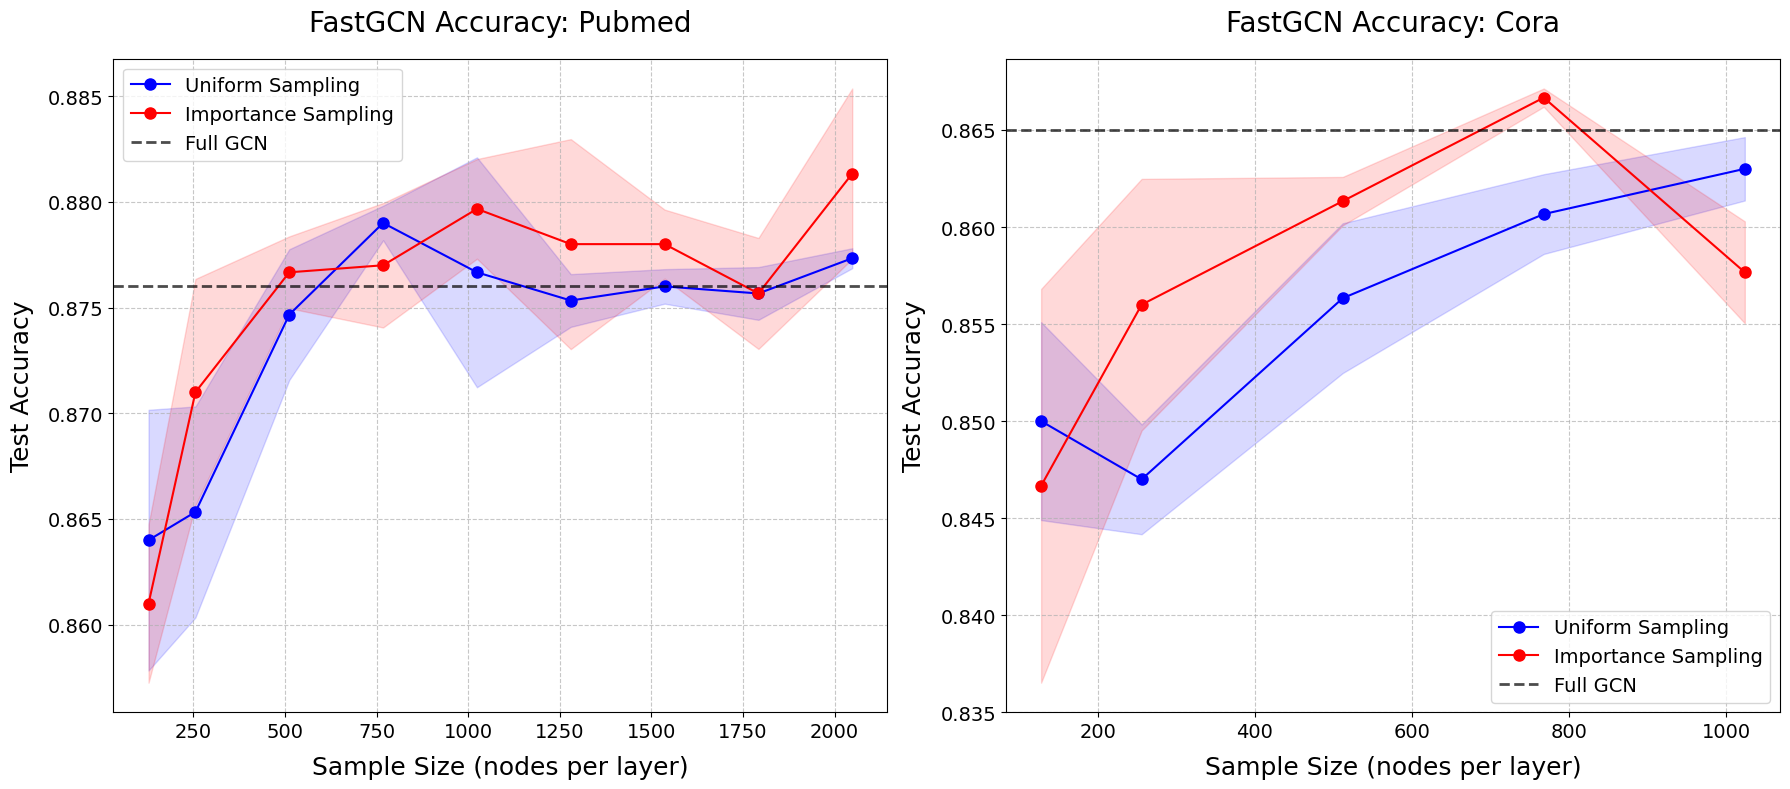

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data: Pubmed ---
pm_ss = [128, 256, 512, 768, 1024, 1280, 1536, 1792, 2048]
pm_uni_mean = [0.864, 0.86533333, 0.87466667, 0.879, 0.87666667, 0.87533333, 0.876, 0.87566667, 0.87733333]
pm_uni_std = [0.00616441, 0.00498888, 0.00309121, 0.0008165, 0.0054365, 0.00124722, 0.0008165, 0.00124722, 0.0004714]

pm_imp_mean = [0.861, 0.871, 0.87666667, 0.877, 0.87966667, 0.878, 0.878, 0.87566667, 0.88133333]
pm_imp_std = [0.00374166, 0.00535413, 0.00169967, 0.00294392, 0.00235702, 0.00496655, 0.00163299, 0.00262467, 0.00402768]

# --- Data: Cora ---
cora_ss = [128, 256, 512, 768, 1024]
cora_uni_mean = [0.85, 0.847, 0.85633333, 0.86066667, 0.863]
cora_uni_std = [0.00509902, 0.00282843, 0.00385861, 0.0020548, 0.00163299]

cora_imp_mean = [0.84666667, 0.856, 0.86133333, 0.86666667, 0.85766667]
cora_imp_std = [0.01014342, 0.00648074, 0.00124722, 0.0004714, 0.00262467]

# Baselines
full_gcn_pubmed = 0.876
full_gcn_cora = 0.865

# --- Font Size Configuration ---
TITLE_SIZE = 20
LABEL_SIZE = 18
TICK_SIZE = 14
LEGEND_SIZE = 14

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Pubmed
ax1.plot(pm_ss, pm_uni_mean, marker='o', markersize=8, linestyle='-', color='blue', label='Uniform Sampling')
ax1.fill_between(pm_ss, np.array(pm_uni_mean) - np.array(pm_uni_std),
                 np.array(pm_uni_mean) + np.array(pm_uni_std), color='blue', alpha=0.15)

ax1.plot(pm_ss, pm_imp_mean, marker='o', markersize=8, linestyle='-', color='red', label='Importance Sampling')
ax1.fill_between(pm_ss, np.array(pm_imp_mean) - np.array(pm_imp_std),
                 np.array(pm_imp_mean) + np.array(pm_imp_std), color='red', alpha=0.15)

ax1.axhline(y=full_gcn_pubmed, color='black', linestyle='--', label='Full GCN', alpha=0.7, linewidth=2)
ax1.set_title('FastGCN Accuracy: Pubmed', fontsize=TITLE_SIZE, pad=20)
ax1.set_xlabel('Sample Size (nodes per layer)', fontsize=LABEL_SIZE, labelpad=10)
ax1.set_ylabel('Test Accuracy', fontsize=LABEL_SIZE, labelpad=10)
ax1.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=LEGEND_SIZE)

# Plot 2: Cora
ax2.plot(cora_ss, cora_uni_mean, marker='o', markersize=8, linestyle='-', color='blue', label='Uniform Sampling')
ax2.fill_between(cora_ss, np.array(cora_uni_mean) - np.array(cora_uni_std),
                 np.array(cora_uni_mean) + np.array(cora_uni_std), color='blue', alpha=0.15)

ax2.plot(cora_ss, cora_imp_mean, marker='o', markersize=8, linestyle='-', color='red', label='Importance Sampling')
ax2.fill_between(cora_ss, np.array(cora_imp_mean) - np.array(cora_imp_std),
                 np.array(cora_imp_mean) + np.array(cora_imp_std), color='red', alpha=0.15)

ax2.axhline(y=full_gcn_cora, color='black', linestyle='--', label='Full GCN', alpha=0.7, linewidth=2)
ax2.set_title('FastGCN Accuracy: Cora', fontsize=TITLE_SIZE, pad=20)
ax2.set_xlabel('Sample Size (nodes per layer)', fontsize=LABEL_SIZE, labelpad=10)
ax2.set_ylabel('Test Accuracy', fontsize=LABEL_SIZE, labelpad=10)
ax2.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(fontsize=LEGEND_SIZE)

plt.tight_layout()
plt.show()